## Description:

        Investigate OTU classification in controls and mock community for the ERA MiSeq run



In [1]:
Controls = "/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/controls.rds"

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

In [5]:
%%R -i Controls
phy = readRDS(Controls)
phy = prune_taxa(taxa_sums(phy) > 3, phy)
phy 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 353 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 353 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 353 tips and 352 internal nodes ]


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [6]:
%%R
t = tax_table(phy)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(phy) = t

### Filter by removing taxa not seen in more than  3 counts in more than 3 samples  

In [6]:
# %%R 

# # filtering/normalizing
# #physeq.snorm = transform_sample_counts(physeq, function(x) x/sum(x))
# physeq.thresh = filter_taxa(physeq, function(x) sum(x > 3) > 3, TRUE)
# print(physeq.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4987 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4987 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4987 tips and 4986 internal nodes ]


## Controls 

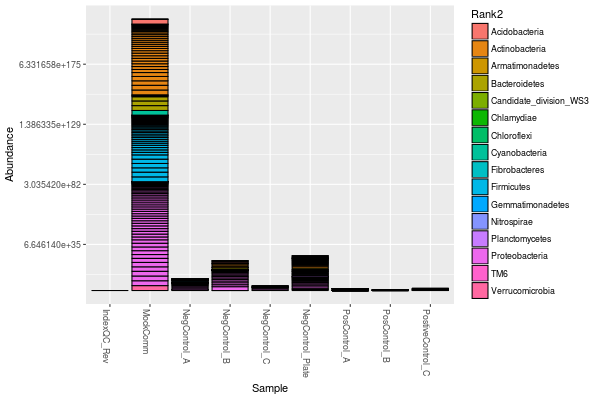

In [9]:
%%R -w 600 -h 400
plot_bar(phy, fill = 'Rank2', x = "Sample") +
    scale_y_continuous(trans='log2')

In [10]:
%%R
phy %>%
    sample_data %>%
    colnames

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "SampleWellID"    "PrimerPlate"     "PrimerNumber"    "PrimerWell"     
 [9] "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"     "rev_barcode"    
[13] "PlotID"          "TimePoint"       "Rep"             "Row"            
[17] "Pos"             "Fert"            "PlotIndex"       "Plant"          
[21] "Genotype"        "SeedTreatment"   "R_Year"          "ERA"            
[25] "kgdw_ha"         "FracN.leco"      "FracC.leco"      "d15N"           
[29] "X15N_AtPercent"  "FracN"           "FracN_fromSoil"  "FracN_fromFert" 


In [11]:
%%R
Mock = subset_samples(phy, X.sampleID == "MockComm")
Mock = prune_taxa(taxa_sums(Mock) > 3, Mock)

# NegControl = subset_samples(phy, X.sample %in% "NegControl-1")
# Pos = prune_taxa(taxa_sums(Pos) > 0, Pos)
# tax_table(Pos)
Mock_n = unique(tax_table(Mock)) %>% dim %>% .[1]
Mock_n
(Mock_n)
paste("OTUs recovered in MockCommunity: ", as.character(Mock_n), sep = "" )


[1] "OTUs recovered in MockCommunity: 46"


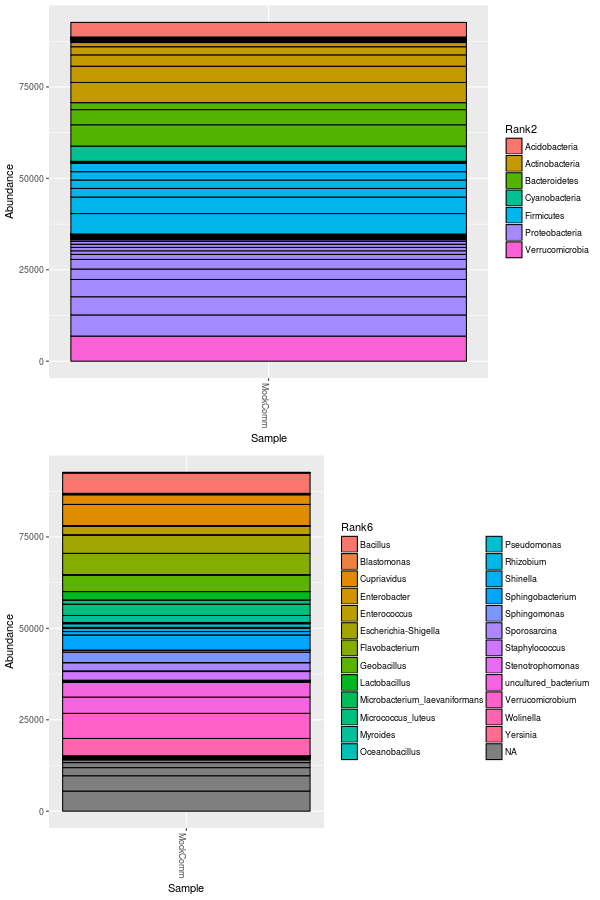

In [12]:
%%R -w 600 -h 900
p1 = plot_bar(Mock, fill = 'Rank2', x = "Sample")

p2 = plot_bar(Mock, fill = 'Rank6', x = "Sample")

grid.arrange(p1, p2, ncol=1)

# Comparing mock community OTU composition to table of 'true' mock community composition

In [17]:
%%R 

mock.known = read.delim('/home/bryan/RhizCG/data/MiSeq_amplicon/Hay-lab_mock_community/strain_taxonomy.txt')
mock.known = mock.known$phylum %>% table %>% as.data.frame
colnames(mock.known) = c('phylum', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known %>% print(n = 20)

# A tibble: 5 × 3
          phylum freq.known freq.known.norm
          <fctr>      <int>           <dbl>
1 Actinobacteria          4      0.10526316
2  Bacteroidetes          2      0.05263158
3     Firmicutes          8      0.21052632
4 Proteobacteria         23      0.60526316
5   Spirochaetes          1      0.02631579


## Comparing relative compositions of phylum

In [18]:
%%R

Mock.snorm = transform_sample_counts(Mock, function(x) x/sum(x))

tbl.otu = Mock.snorm %>% otu_table %>% as.data.frame
tbl.otu$otu = rownames(tbl.otu)

tbl.otu = tbl.otu %>%
    gather('sample', 'abundance', 1:(ncol(tbl.otu)-1)) %>%
    group_by(otu) %>%
    mutate(total_abund = sum(abundance))

tbl.otu

Source: local data frame [104 x 4]
Groups: otu [104]

         otu   sample    abundance  total_abund
       <chr>    <chr>        <dbl>        <dbl>
1  OTU.12538 MockComm 5.288550e-04 5.288550e-04
2  OTU.13761 MockComm 9.357495e-03 9.357495e-03
3  OTU.13361 MockComm 8.029961e-03 8.029961e-03
4  OTU.14267 MockComm 6.583705e-04 6.583705e-04
5  OTU.12609 MockComm 9.713663e-05 9.713663e-05
6   OTU.8697 MockComm 1.802424e-03 1.802424e-03
7     OTU.69 MockComm 1.000507e-02 1.000507e-02
8  OTU.12116 MockComm 3.085707e-02 3.085707e-02
9  OTU.14214 MockComm 3.885465e-04 3.885465e-04
10   OTU.547 MockComm 5.040312e-03 5.040312e-03
# ... with 94 more rows


In [19]:
%%R
tbl.tax = Mock.snorm %>% tax_table %>% as.data.frame
tbl.tax$otu = rownames(tbl.tax)

tbl.j = inner_join(tbl.otu, tbl.tax, c('otu' = 'otu'))
tbl.j %>% head(n=3)

Source: local data frame [3 x 12]
Groups: otu [3]

        otu   sample   abundance total_abund    Rank1          Rank2
      <chr>    <chr>       <dbl>       <dbl>   <fctr>         <fctr>
1 OTU.12538 MockComm 0.000528855 0.000528855 Bacteria Proteobacteria
2 OTU.13761 MockComm 0.009357495 0.009357495 Bacteria Proteobacteria
3 OTU.13361 MockComm 0.008029961 0.008029961 Bacteria Proteobacteria
# ... with 6 more variables: Rank3 <fctr>, Rank4 <fctr>, Rank5 <fctr>,
#   Rank6 <fctr>, Rank7 <fctr>, Rank8 <fctr>


In [20]:
%%R
tbl.j %>% arrange(desc(abundance)) %>%
    select(-otu, -sample, -Rank1) %>%
    print(n = 69)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Adding missing grouping variables: `otu`

  warnings.warn(x, RRuntimeWarning)


Source: local data frame [104 x 10]
Groups: otu [104]

         otu    abundance  total_abund           Rank2                 Rank3
       <chr>        <dbl>        <dbl>          <fctr>                <fctr>
1    OTU.143 0.0741800050 0.0741800050 Verrucomicrobia      Verrucomicrobiae
2    OTU.282 0.0628258124 0.0628258124   Bacteroidetes         Flavobacteria
3    OTU.539 0.0623833011 0.0623833011  Proteobacteria    Betaproteobacteria
4    OTU.440 0.0603326390 0.0603326390      Firmicutes               Bacilli
5    OTU.295 0.0593936516 0.0593936516  Actinobacteria         Micrococcales
6    OTU.484 0.0536086257 0.0536086257  Proteobacteria   Gammaproteobacteria
7    OTU.333 0.0510075227 0.0510075227  Proteobacteria Epsilonproteobacteria
8    OTU.619 0.0486330718 0.0486330718      Firmicutes               Bacilli
9   OTU.1982 0.0480826309 0.0480826309  Actinobacteria         Micrococcales
10   OTU.442 0.0451685320 0.0451685320   Cyanobacteria           SubsectionI
11   OTU.637 0.044769

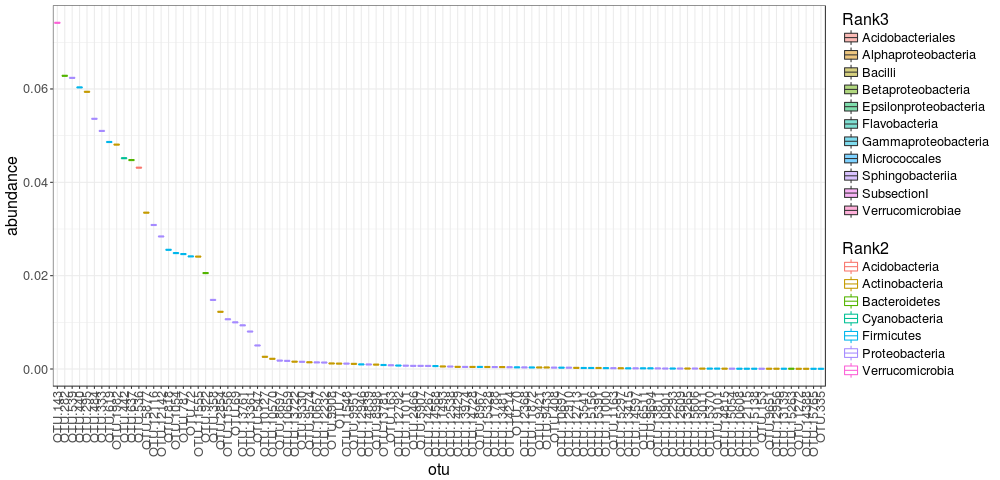

In [21]:
%%R -w 1000 

tbl.j$otu = reorder(tbl.j$otu, -tbl.j$total_abund)

ggplot(tbl.j, aes(otu, abundance, color=Rank2, fill=Rank3)) +
    geom_boxplot(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [22]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est 

# A tibble: 7 × 3
           phylum freq.est freq.est.norm
           <fctr>    <int>         <dbl>
1   Acidobacteria        1   0.009615385
2  Actinobacteria       30   0.288461538
3   Bacteroidetes        4   0.038461538
4   Cyanobacteria        1   0.009615385
5      Firmicutes       29   0.278846154
6  Proteobacteria       38   0.365384615
7 Verrucomicrobia        1   0.009615385


In [23]:
%%R

mock.j = full_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm) 

mock.j

# A tibble: 16 × 5
            phylum freq.est freq.known        variable       value
             <chr>    <int>      <int>           <chr>       <dbl>
1    Acidobacteria        1         NA   freq.est.norm 0.009615385
2   Actinobacteria       30          4   freq.est.norm 0.288461538
3    Bacteroidetes        4          2   freq.est.norm 0.038461538
4    Cyanobacteria        1         NA   freq.est.norm 0.009615385
5       Firmicutes       29          8   freq.est.norm 0.278846154
6   Proteobacteria       38         23   freq.est.norm 0.365384615
7  Verrucomicrobia        1         NA   freq.est.norm 0.009615385
8     Spirochaetes       NA          1   freq.est.norm          NA
9    Acidobacteria        1         NA freq.known.norm          NA
10  Actinobacteria       30          4 freq.known.norm 0.105263158
11   Bacteroidetes        4          2 freq.known.norm 0.052631579
12   Cyanobacteria        1         NA freq.known.norm          NA
13      Firmicutes       29          8 freq

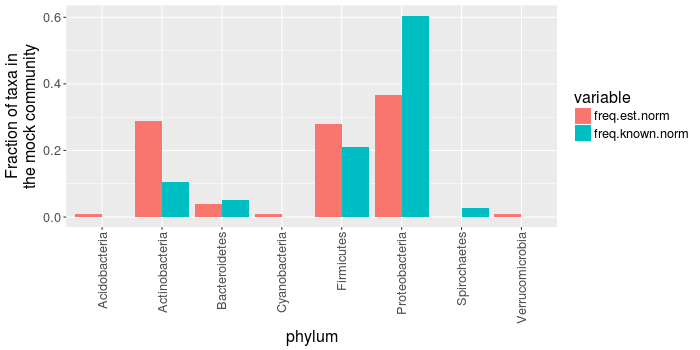

In [24]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

### Filtering out low abundance taxa

In [25]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    filter(abundance > 0.01) %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est 

# A tibble: 7 × 3
           phylum freq.est freq.est.norm
           <fctr>    <int>         <dbl>
1   Acidobacteria        1          0.04
2  Actinobacteria        5          0.20
3   Bacteroidetes        3          0.12
4   Cyanobacteria        1          0.04
5      Firmicutes        6          0.24
6  Proteobacteria        8          0.32
7 Verrucomicrobia        1          0.04


In [26]:
%%R

mock.j = left_join(mock.est, mock.known, c('phylum' = 'phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm)

mock.j 

# A tibble: 14 × 5
            phylum freq.est freq.known        variable      value
             <chr>    <int>      <int>           <chr>      <dbl>
1    Acidobacteria        1         NA   freq.est.norm 0.04000000
2   Actinobacteria        5          4   freq.est.norm 0.20000000
3    Bacteroidetes        3          2   freq.est.norm 0.12000000
4    Cyanobacteria        1         NA   freq.est.norm 0.04000000
5       Firmicutes        6          8   freq.est.norm 0.24000000
6   Proteobacteria        8         23   freq.est.norm 0.32000000
7  Verrucomicrobia        1         NA   freq.est.norm 0.04000000
8    Acidobacteria        1         NA freq.known.norm         NA
9   Actinobacteria        5          4 freq.known.norm 0.10526316
10   Bacteroidetes        3          2 freq.known.norm 0.05263158
11   Cyanobacteria        1         NA freq.known.norm         NA
12      Firmicutes        6          8 freq.known.norm 0.21052632
13  Proteobacteria        8         23 freq.known.norm 0.

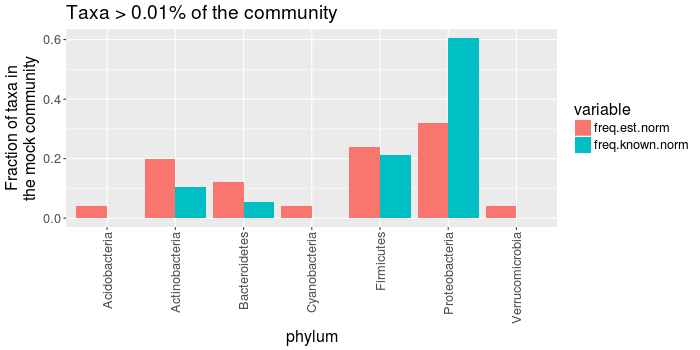

In [27]:
%%R -w 700 -h 350

ggplot(mock.j, aes(phylum, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community', title='Taxa > 0.01% of the community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

## Comparing relative compositions of 

In [34]:
%%R 

mock.known = read.delim('/home/bryan/RhizCG/data/MiSeq_amplicon/Hay-lab_mock_community/strain_taxonomy.txt', sep='\t')

mock.known = mock.known$genus %>% table %>% as.data.frame
colnames(mock.known) = c('genus', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known 

# A tibble: 34 × 3
            genus freq.known freq.known.norm
           <fctr>      <int>           <dbl>
1   Achromobacter          1      0.02631579
2   Agrobacterium          1      0.02631579
3     Alcaligenes          2      0.05263158
4    Arthrobacter          1      0.02631579
5        Bacillus          2      0.05263158
6    Enterobacter          1      0.02631579
7    Enterococcus          1      0.02631579
8     Escherichia          1      0.02631579
9  Flavobacterium          1      0.02631579
10    Geobacillus          1      0.02631579
# ... with 24 more rows


In [35]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    mutate(Rank6 = gsub('^__', '', Rank6), 
           Rank6 = gsub('uncultured_', '', Rank6)) %>%
    group_by(otu, Rank6) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank6) 

mock.est = tmp$Rank6 %>% table %>% as.data.frame
colnames(mock.est) = c('genus', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est %>% head

# A tibble: 6 × 3
         genus freq.est freq.est.norm
        <fctr>    <int>         <dbl>
1     Bacillus        7    0.09459459
2    bacterium       10    0.13513514
3  Blastomonas        1    0.01351351
4  Cupriavidus        6    0.08108108
5 Enterobacter        3    0.04054054
6 Enterococcus        1    0.01351351


In [36]:
%%R

mock.j = full_join(mock.est, mock.known, by = c('genus' = 'genus')) %>%
    arrange(genus)
#     gather('variable', 'value', freq.est.norm, freq.known.norm) %>%
#     group_by(variable)

mock.j %>% print(n = 51)

# A tibble: 48 × 5
                           genus freq.est freq.est.norm freq.known
                           <chr>    <int>         <dbl>      <int>
1                  Achromobacter       NA            NA          1
2                  Agrobacterium       NA            NA          1
3                    Alcaligenes       NA            NA          2
4                   Arthrobacter       NA            NA          1
5                       Bacillus        7    0.09459459          2
6                      bacterium       10    0.13513514         NA
7                    Blastomonas        1    0.01351351         NA
8                    Cupriavidus        6    0.08108108         NA
9                   Enterobacter        3    0.04054054          1
10                  Enterococcus        1    0.01351351          1
11                   Escherichia       NA            NA          1
12          Escherichia-Shigella        2    0.02702703         NA
13                Flavobacterium        1  

In [38]:
%%R -w 700 -h 450

ggplot(mock.j, aes(genus, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

RRuntimeError: Error in eval(expr, envir, enclos) : object 'value' not found


### Conclusions

* The number of OTUs in the sequenced mock is pretty similar to the actual number of taxa in the community
  * 43 estimated compared to 39 actual
* The community composition between sequenced and true communities is:
  * Similar at the phylum level
  * Not too accurate at the genus level

## Identify taxa in negative controls

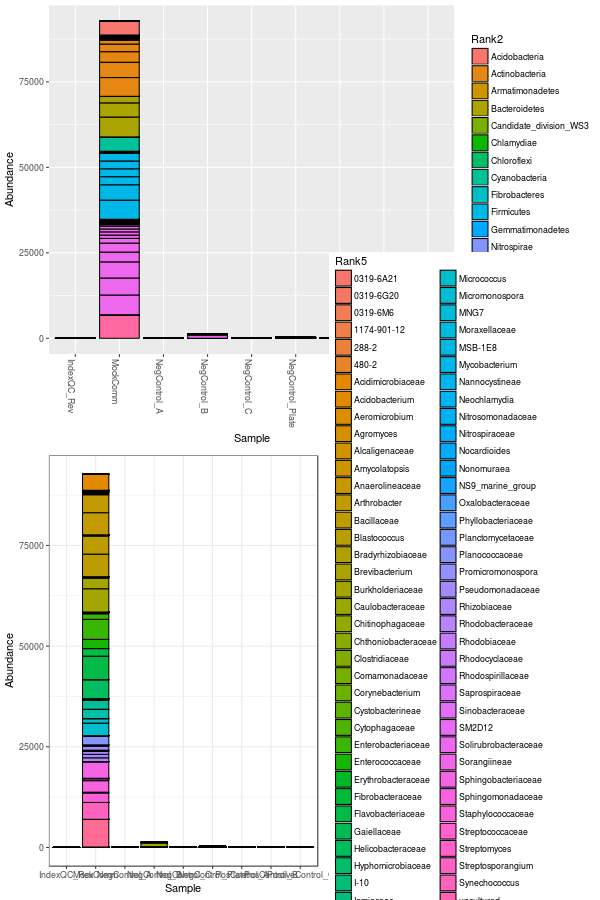

In [39]:
%%R -w 600 -h 900

p1 = plot_bar(phy, fill = 'Rank2', x = "Sample")

p2 = plot_bar(phy, fill = 'Rank5', x = "Sample") +
        theme_bw() +
        theme(plot.title = element_text(face="bold", size=20)) +
        guides(fill=guide_legend(ncol=2))

grid.arrange(p1, p2, ncol=1)

## Save OTUs in negative controls

In [57]:
%%R
phy %>% sample_data %>%
    select(X.sampleID)

Sample Data:        [4 samples by 1 sample variables]:
                     X.sampleID
MockCommunity-1 MockCommunity-1
NegControl-1       NegControl-1
NegControl-2       NegControl-2
PosControl-1       PosControl-1


In [40]:
%%R
NegControl = subset_samples(phy, X.sampleID %in% c("NegControl_A","NegControl_B", "NegControl_C",
                                                    "NegControl_Plate"))

NegControl = prune_taxa(taxa_sums(NegControl) > 0, NegControl)
NegControl


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 163 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 163 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 163 tips and 162 internal nodes ]


In [41]:
%%R
FalsePositives = filter_taxa(NegControl, function(x) sum(x > 0) > 0, TRUE) %>% taxa_names()
     

In [42]:
%%R
FalsePositives = filter_taxa(NegControl, function(x) sum(x > 0) > 0, TRUE) %>% taxa_names()

#Positives = filter_taxa(NegControl, function(x) sum(x > 0) < 1, TRUE) %>% taxa_names()

controls.FP = prune_taxa(FalsePositives, phy)  

controls.FP


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 163 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 163 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 163 tips and 162 internal nodes ]


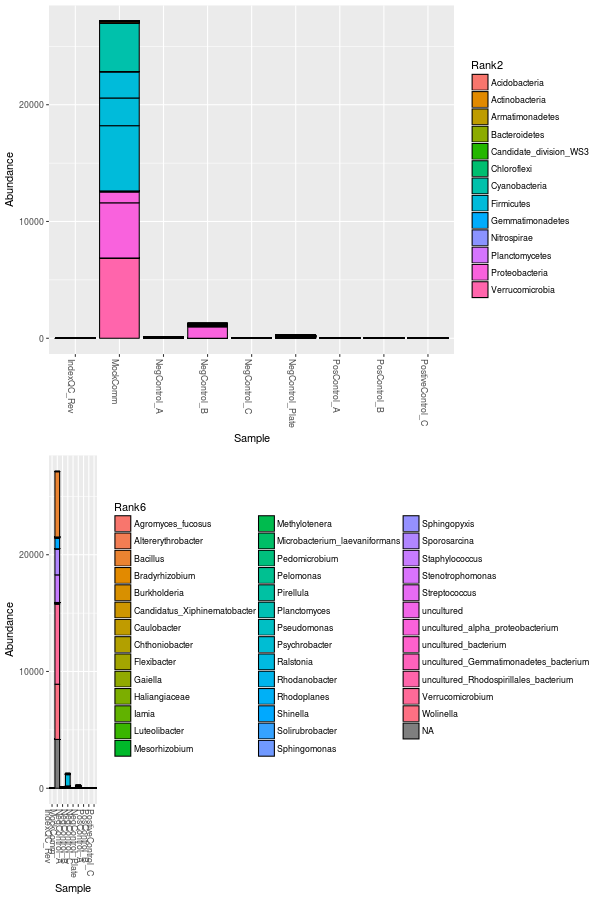

In [43]:
%%R -w 600 -h 900
# false positive composition in controls

p1 = plot_bar(controls.FP, fill = 'Rank2', x = "Sample")

p2 = plot_bar(controls.FP, fill = 'Rank6', x = "Sample")

grid.arrange(p1, p2, ncol=1)

In [63]:
%%R
tmp = controls.FP %>% subset_samples(X.sampleID == "MockComm")
tmp = prune_taxa(taxa_sums(tmp)>0, tmp)
tmp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 15 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 15 tips and 14 internal nodes ]


In [65]:
%%R
mdf = psmelt(tmp)
mdf$relAbundance = mdf$Abundance / 92710

In [68]:
%%R
mdf %>% select(OTU, relAbundance, Rank2, Rank3, Rank4, Rank5, Rank6)

        OTU relAbundance           Rank2                 Rank3
4   OTU.143 7.413440e-02 Verrucomicrobia      Verrucomicrobiae
7   OTU.440 6.029555e-02      Firmicutes               Bacilli
6   OTU.333 5.097616e-02  Proteobacteria Epsilonproteobacteria
8   OTU.442 4.514076e-02   Cyanobacteria           SubsectionI
14  OTU.818 2.553123e-02      Firmicutes               Bacilli
13   OTU.72 2.410743e-02      Firmicutes               Bacilli
10   OTU.69 9.998921e-03  Proteobacteria   Alphaproteobacteria
11    OTU.7 1.164923e-03  Actinobacteria         Micrococcales
5   OTU.163 7.981879e-04  Proteobacteria   Gammaproteobacteria
12   OTU.70 3.559487e-04      Firmicutes               Bacilli
2  OTU.1163 1.725812e-04  Proteobacteria   Gammaproteobacteria
3  OTU.1272 4.314529e-05  Actinobacteria         Micrococcales
1    OTU.11 1.078632e-05  Proteobacteria    Betaproteobacteria
9   OTU.678 1.078632e-05  Proteobacteria    Betaproteobacteria
15   OTU.99 1.078632e-05  Actinobacteria     Corynebact

In [70]:
%%R
mock.known = read.delim('/home/bryan/RhizCG/data/MiSeq_amplicon/Hay-lab_mock_community/strain_taxonomy.txt', sep='\t')

mock.known = mock.known$genus %>% table %>% as.data.frame
colnames(mock.known) = c('genus', 'freq.known')

mock.known = mock.known %>%
    group_by() %>%
    mutate(freq.known.norm = freq.known / sum(freq.known))

mock.known %>% print(n = 34)

# A tibble: 34 × 3
               genus freq.known freq.known.norm
              <fctr>      <int>           <dbl>
1      Achromobacter          1      0.02631579
2      Agrobacterium          1      0.02631579
3        Alcaligenes          2      0.05263158
4       Arthrobacter          1      0.02631579
5           Bacillus          2      0.05263158
6       Enterobacter          1      0.02631579
7       Enterococcus          1      0.02631579
8        Escherichia          1      0.02631579
9     Flavobacterium          1      0.02631579
10       Geobacillus          1      0.02631579
11        Klebsiella          2      0.05263158
12           Kocuria          1      0.02631579
13     Lactobacillus          1      0.02631579
14       Lactococcus          1      0.02631579
15        Leptothrix          1      0.02631579
16       Micrococcus          1      0.02631579
17      Nocardioides          1      0.02631579
18  Novosphingomonas          1      0.02631579
19 Novosphingomonas  

# Check abundance of false positives in overall dataset

In [44]:
%%R
ERA = readRDS('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds')


    
#Filter to false positives
ERA.FP = prune_taxa(FalsePositives, ERA) 
ERA.FP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 145 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 145 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 145 tips and 144 internal nodes ]


In [48]:
%%R
sample_data(ERA.FP)$Planted = ifelse(sample_data(ERA.FP)$Genotype == "Bare", "Bare", "Rhizosphere")

In [49]:
%%R

mdf = ERA.FP %>% psmelt()

In [50]:
%%R
MeanFP = mdf %>% 
    filter(TimePoint != "T0") %>%
    group_by(OTU, Planted) %>%
    summarise(MeanAbund = mean(Abundance)) %>%
    arrange(desc(MeanAbund)) 

Taxa = tax_table(phy) %>% as.data.frame
Taxa$OTU = row.names(Taxa)

MeanFP = left_join(MeanFP, Taxa, by = "OTU")

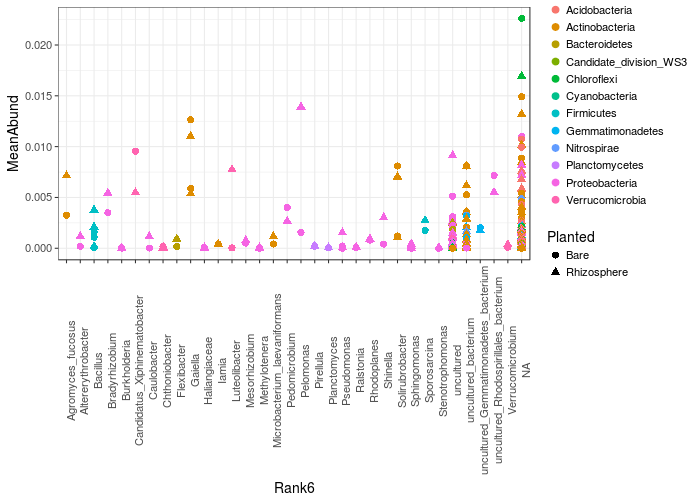

In [51]:
%%R -w 700 -h 500
ggplot(MeanFP, aes(x = Rank6, y = MeanAbund, shape = Planted, color = Rank2)) +
geom_point(size = 3)+
theme_bw(base_size = 14) +
theme(axis.text.x = element_text(angle = 90))

# Do negative controls display a biological pattern

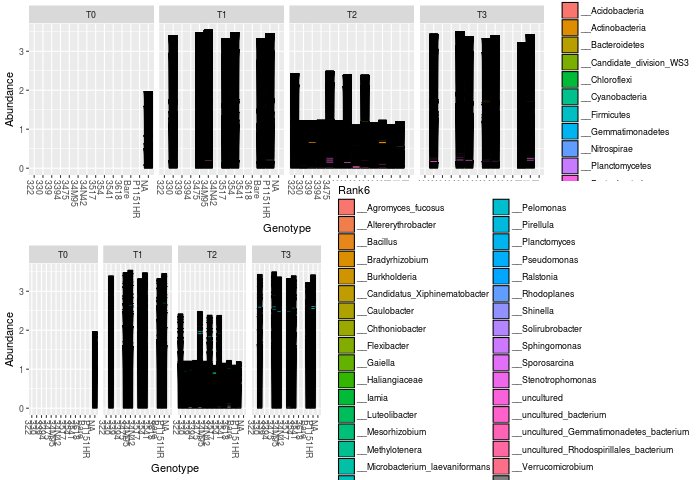

In [53]:
%%R -w 700
# false positive composition in controls

p1 = plot_bar(ERA.FP, fill = 'Rank2', x = "Genotype") +
    facet_wrap(~TimePoint, ncol = 5)

p2 = plot_bar(ERA.FP, fill = 'Rank6', x = "Genotype") +
    facet_wrap(~TimePoint, ncol = 5)

grid.arrange(p1, p2, ncol=1)

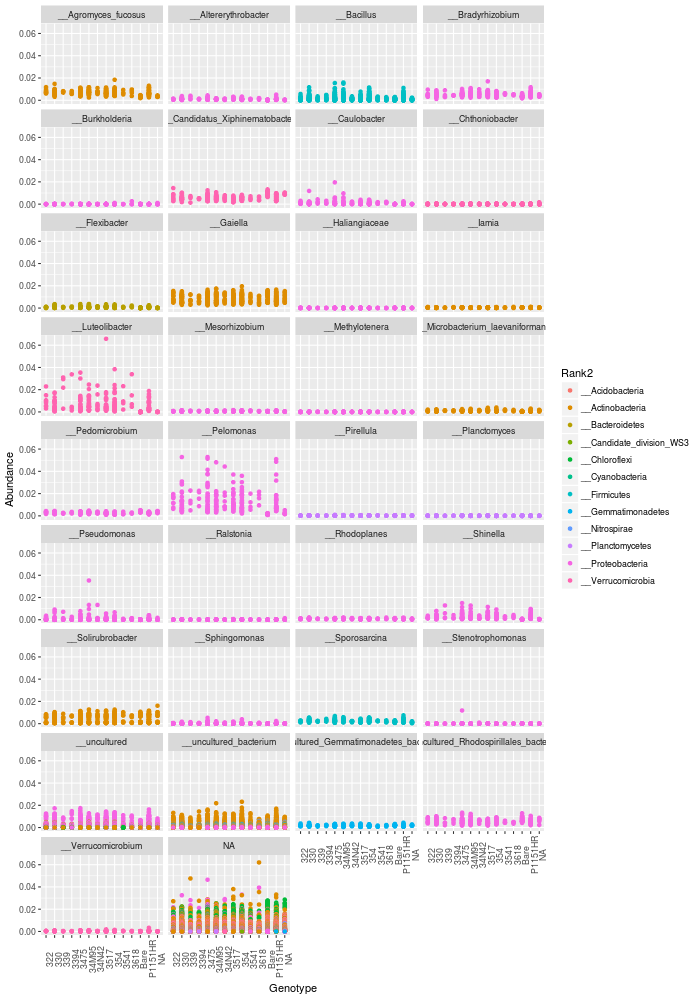

In [54]:
%%R -w 700 -h 1000
ggplot(mdf, aes(x = Genotype, y = Abundance, color = Rank2)) + 
    geom_point() + 
    facet_wrap(~Rank6, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90))

In [55]:
%%R
sample_sums(phy)

        MockComm     NegControl_A NegControl_Plate     PosControl_B 
           92710              150              264               29 
    NegControl_B     PosControl_A PostiveControl_C     NegControl_C 
            1271               74               26               38 
     IndexQC_Rev 
               1 


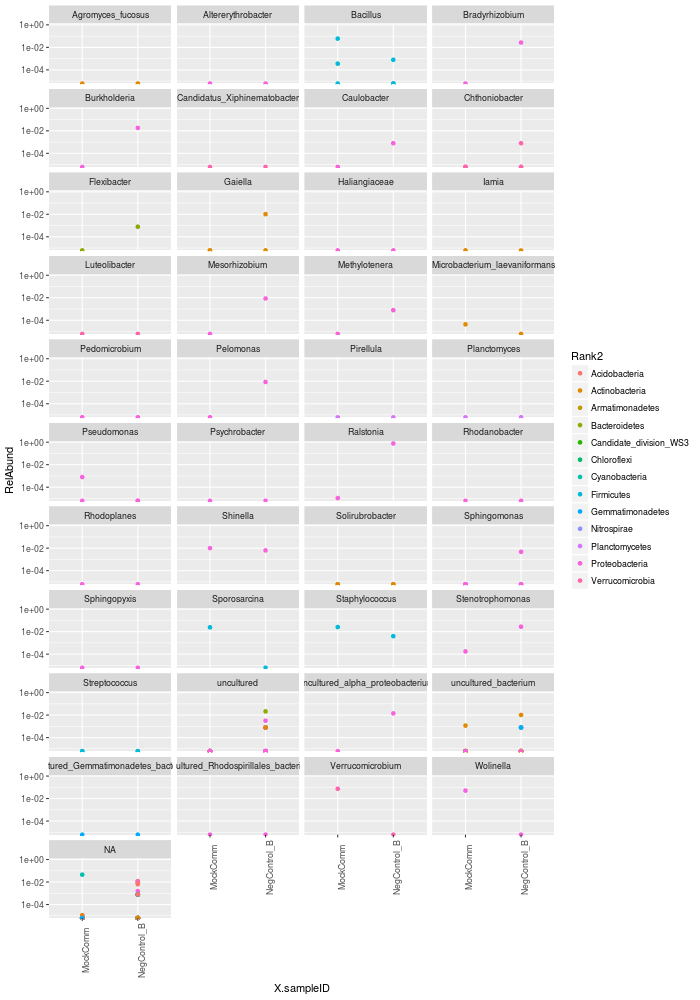

In [59]:
%%R -w 700 -h 1000

tmp = subset_samples(controls.FP, X.sampleID %in% c("MockComm", "NegControl_B"))
c.mdf=psmelt(tmp)

c.mdf = mutate(c.mdf, RelAbund = ifelse(X.sampleID == "MockComm", Abundance/92710, 
                                     Abundance/1271)) 


ggplot(c.mdf, aes(x = X.sampleID, y = RelAbund, color = Rank2)) + 
    geom_point() + 
    facet_wrap(~Rank6, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90)) +
    scale_y_log10()

* Negative controls show sequences
* There was no amplification of negative controls per gel visualization monitoring
* Of false positives, only pseudomonas shows up in appreciable ammounts in Mock community 
* Neg Control had only 686 reads, one tenth of the lowest sample count 
* Unlikely that contamination is contributing greatly to samples
* Genus designations are suspect